In [11]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss

# **[NOWE]** dodatkowe importy do metryk
from sklearn.metrics import roc_auc_score, average_precision_score

print("start")
# --- 1. Load and preprocess edge list ---
# Expect 'interactions_modified1.csv' in the same directory; columns: protein1 protein2 combined_score

df = pd.read_csv(
    'interactions_modified1.csv', sep=r'\s+', names=['protein1', 'protein2', 'combined_score'],
    dtype={'protein1': str, 'protein2': str, 'combined_score': str}, engine='python'
)
# Filter out invalid or missing scores, convert to float
df = df[pd.to_numeric(df['combined_score'], errors='coerce').notnull()]
df['combined_score'] = df['combined_score'].astype(float)

# Map protein IDs to integer node indices
genes = pd.unique(df[['protein1', 'protein2']].values.ravel())
mapping = {g: i for i, g in enumerate(genes)}
u = df['protein1'].map(mapping).to_numpy()
v = df['protein2'].map(mapping).to_numpy()

# Train/test split of edges (80/20)
all_idx = np.arange(len(u))
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=42)

u_train, v_train = u[train_idx], v[train_idx]
u_test, v_test   = u[test_idx],  v[test_idx]

# Create symmetric train and test edge_index arrays
train_edges = np.vstack([u_train, v_train])
train_edges = np.concatenate([train_edges, train_edges[::-1]], axis=1)

test_pos_edges = np.vstack([u_test, v_test])              # **[NOWE]** tylko pozytywne krawędzie
test_pos_edges = np.concatenate([test_pos_edges, test_pos_edges[::-1]], axis=1)

# --- 2. Build PyG Data object ---
num_nodes = len(genes)
train_edge_index = torch.from_numpy(train_edges.astype(np.int64))

data = Data(edge_index=train_edge_index, num_nodes=num_nodes)

# --- 3. Define GraphSAGE model with Embedding ---
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_nodes, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_nodes, embed_dim)
        self.conv1 = SAGEConv(embed_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.lin   = torch.nn.Linear(hidden_dim * 2, 1)

    def forward(self, edge_index, edge_label_index):
        x = self.embedding.weight
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        src, dst = edge_label_index
        emb = torch.cat([x[src], x[dst]], dim=1)
        return self.lin(emb).view(-1)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GraphSAGE(num_nodes=num_nodes, embed_dim=32, hidden_dim=64).to(device)
data = data.to(device)
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# --- 4. Training and evaluation functions ---
def train():
    model.train()
    optimizer.zero_grad()

    # Positive edges (wszystkie w grafie treningowym)
    pos_edge_index = data.edge_index
    num_pos = pos_edge_index.size(1)
    pos_labels = torch.ones(num_pos, device=device)

    # Negative sampling: tyle samo negatywnych co pozytywnych
    neg_edge = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_pos,
        method='sparse'
    )
    neg_labels = torch.zeros(neg_edge.size(1), device=device)

    # Combine edges and labels
    edge_label_index = torch.cat([pos_edge_index, neg_edge], dim=1)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # Forward i backward
    out = model(data.edge_index, edge_label_index)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()

    # --- [NOWE] Tworzymy zestaw testowy z krawędzi pozytywnych i negatywnych ---
    # 1) Pozytywne krawędzie: test_pos_edges (symetryczne w dwie strony)
    pos_edge_index = torch.from_numpy(test_pos_edges.astype(np.int64)).to(device)
    num_pos_test = pos_edge_index.size(1)
    pos_labels_test = torch.ones(num_pos_test, device=device)

    # 2) Negatywne krawędzie: wygenerowane z zadaną liczbą próbek
    neg_edge_test = negative_sampling(
        edge_index=data.edge_index,      # lub można użyć train_edge_index – w każdym razie sampling po nodach
        num_nodes=data.num_nodes,
        num_neg_samples=num_pos_test,
        method='sparse'
    ).to(device)
    neg_labels_test = torch.zeros(neg_edge_test.size(1), device=device)

    # 3) Połączmy krawędzie i etykiety
    edge_label_index_test = torch.cat([pos_edge_index, neg_edge_test], dim=1)
    labels_test = torch.cat([pos_labels_test, neg_labels_test], dim=0)  # tensor kształtu (2*num_pos_test,)

    # 4) Zrób predykcje (logity) i oblicz sigmoid dla prawdopodobieństw
    logits = model(data.edge_index, edge_label_index_test)
    probs = torch.sigmoid(logits).cpu().numpy()
    labels_np = labels_test.cpu().numpy()

    # --- [NOWE] 5) Obliczenie metryk ROC AUC oraz Average Precision ---
    auc_roc = roc_auc_score(labels_np, probs)
    avg_prec = average_precision_score(labels_np, probs)

    return {
        'probs': probs,               # wektor prawdopodobieństw dla wszystkich krawędzi testowych (pozytywnych+negatywnych)
        'labels': labels_np,          # wektor prawdziwych etykiet (1 dla pozytywnych, 0 dla negatywnych)
        'auc_roc': auc_roc,
        'avg_prec': avg_prec
    }

# --- 5. Training loop ---
epochs = 20
for epoch in range(1, epochs + 1):
    loss = train()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")

# --- 6. Evaluate on test set ---
test_res = test()
print(f"AUC-ROC na zbiorze testowym: {test_res['auc_roc']:.4f}")
print(f"Average Precision na zbiorze testowym: {test_res['avg_prec']:.4f}")

# (opcjonalnie) Wypisz kilka pierwszych predykcji:
print("Przykładowe prawdopodobieństwa (pierwsze 10):", test_res['probs'][:10])
print("Przykładowe etykiety (pierwsze 10):", test_res['labels'][:10])


start
cuda
Epoch 05, Loss: 0.7104
Epoch 10, Loss: 0.7026
Epoch 15, Loss: 0.6897
Epoch 20, Loss: 0.6660
AUC-ROC na zbiorze testowym: 0.7009
Average Precision na zbiorze testowym: 0.6616
Przykładowe prawdopodobieństwa (pierwsze 10): [0.5081513  0.5247849  0.53647125 0.4957389  0.54081875 0.56899655
 0.5456784  0.51050514 0.54912245 0.60905576]
Przykładowe etykiety (pierwsze 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
@torch.no_grad()
def test():
    model.eval()

    # --- [NOWE] Tworzymy zestaw testowy z krawędzi pozytywnych i negatywnych ---
    # 1) Pozytywne krawędzie: test_pos_edges (symetryczne w dwie strony)
    pos_edge_index = torch.from_numpy(test_pos_edges.astype(np.int64)).to(device)
    num_pos_test = pos_edge_index.size(1)
    pos_labels_test = torch.ones(num_pos_test, device=device)

    # 2) Negatywne krawędzie: wygenerowane z zadaną liczbą próbek
    neg_edge_test = negative_sampling(
        edge_index=data.edge_index,      # lub można użyć train_edge_index – w każdym razie sampling po nodach
        num_nodes=data.num_nodes,
        num_neg_samples=num_pos_test,
        method='sparse'
    ).to(device)
    neg_labels_test = torch.zeros(neg_edge_test.size(1), device=device)

    # 3) Połączmy krawędzie i etykiety
    edge_label_index_test = torch.cat([pos_edge_index, neg_edge_test], dim=1)
    labels_test = torch.cat([pos_labels_test, neg_labels_test], dim=0)  # tensor kształtu (2*num_pos_test,)

    # 4) Zrób predykcje (logity) i oblicz sigmoid dla prawdopodobieństw
    logits = model(data.edge_index, edge_label_index_test)
    probs = torch.sigmoid(logits).cpu().numpy()
    labels_np = labels_test.cpu().numpy()

    # --- [NOWE] 5) Obliczenie metryk ROC AUC oraz Average Precision ---
    auc_roc = roc_auc_score(labels_np, probs)
    avg_prec = average_precision_score(labels_np, probs)
    roc = roc_curve(labels_np[:1000], probs[:1000])

    return {
        'probs': probs,               # wektor prawdopodobieństw dla wszystkich krawędzi testowych (pozytywnych+negatywnych)
        'labels': labels_np,          # wektor prawdziwych etykiet (1 dla pozytywnych, 0 dla negatywnych)
        'auc_roc': auc_roc,
        'avg_prec': avg_prec,
        'roc': roc
    }

In [25]:
probs_test = test()
probs_test

c:\Users\Ja\Desktop\lsc\projekt\venv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


{'probs': array([0.5081513 , 0.5247849 , 0.53647125, ..., 0.37000433, 0.517201  ,
        0.52037567], dtype=float32),
 'labels': array([1., 1., 1., ..., 0., 0., 0.], dtype=float32),
 'auc_roc': 0.6997829522328685,
 'avg_prec': 0.6605003357536532,
 'roc': (array([nan, nan, nan]),
  array([0.   , 0.001, 1.   ]),
  array([       inf, 0.629511  , 0.30280617], dtype=float32))}

In [29]:
probs_test['roc']

(array([nan, nan, nan]),
 array([0.   , 0.001, 1.   ]),
 array([       inf, 0.629511  , 0.30280617], dtype=float32))

F1‐score (threshold=0.5): 0.7014
AUC‐ROC: 0.7009


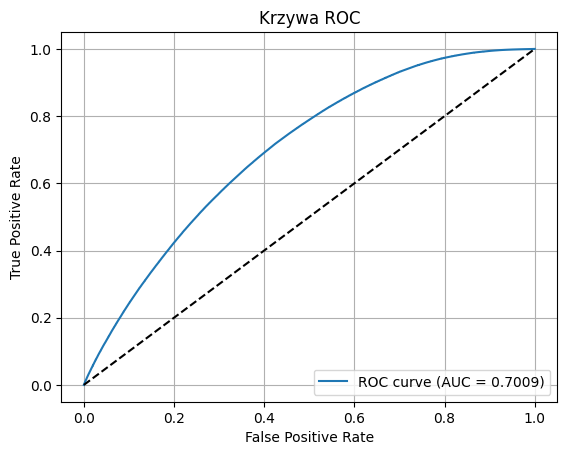

In [31]:
import matplotlib.pyplot as plt

labels = test_res['labels']
probs  = test_res['probs']

# 1) Obliczenie F1‐score przy progu 0.5
pred_labels = (probs >= 0.5).astype(int)
f1 = f1_score(labels, pred_labels)
print(f"F1‐score (threshold=0.5): {f1:.4f}")

# 2) Obliczenie krzywej ROC i AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
auc = roc_auc_score(labels, probs)
print(f"AUC‐ROC: {auc:.4f}")

# 3) Narysowanie krzywej ROC
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')       # linia y = x jako punkt odniesienia
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Krzywa ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

print("start")

# --- 1. Load and preprocess edge list ---
df = pd.read_csv(
    'interactions_modified1.csv', sep=r'\s+', names=['protein1', 'protein2', 'combined_score'],
    dtype={'protein1': str, 'protein2': str, 'combined_score': str}, engine='python'
)
df = df[pd.to_numeric(df['combined_score'], errors='coerce').notnull()]
df['combined_score'] = df['combined_score'].astype(float)

genes = pd.unique(df[['protein1', 'protein2']].values.ravel())
mapping = {g: i for i, g in enumerate(genes)}
u = df['protein1'].map(mapping).to_numpy()
v = df['protein2'].map(mapping).to_numpy()

all_idx = np.arange(len(u))
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=42)
u_train, v_train = u[train_idx], v[train_idx]
u_test, v_test   = u[test_idx],  v[test_idx]

train_edges = np.vstack([u_train, v_train])
train_edges = np.concatenate([train_edges, train_edges[::-1]], axis=1)

test_pos_edges = np.vstack([u_test, v_test])
test_pos_edges = np.concatenate([test_pos_edges, test_pos_edges[::-1]], axis=1)

# --- 2. Build PyG Data object ---
num_nodes = len(genes)
train_edge_index = torch.from_numpy(train_edges.astype(np.int64))
data = Data(edge_index=train_edge_index, num_nodes=num_nodes)

# --- 3. Define GraphSAGE model with Embedding ---
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_nodes, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_nodes, embed_dim)
        self.conv1 = SAGEConv(embed_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.lin   = torch.nn.Linear(hidden_dim * 2, 1)

    def forward(self, edge_index, edge_label_index):
        x = self.embedding.weight
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        src, dst = edge_label_index
        emb = torch.cat([x[src], x[dst]], dim=1)
        return self.lin(emb).view(-1)

# --- 4. Hyperparameters ---
embed_dim = 32
hidden_dim = 64
learning_rate = 0.01
epochs = 5
negative_sampling_method = 'sparse'

# --- 5. Device setup i inicjalizacja modelu/optimera ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Urządzenie treningowe: {device}")

model = GraphSAGE(num_nodes=num_nodes, embed_dim=embed_dim, hidden_dim=hidden_dim).to(device)
data = data.to(device)
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- 6. TensorBoard setup ---
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = os.path.join("runs", f"experiment_{timestamp}")
writer = SummaryWriter(log_dir=log_dir)
print(f"TensorBoard logs będą zapisywane w: {log_dir}")

# --- 7. Funkcja treningowa ---
def train():
    model.train()
    optimizer.zero_grad()

    pos_edge_index = data.edge_index
    num_pos = pos_edge_index.size(1)
    pos_labels = torch.ones(num_pos, device=device)

    neg_edge = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_pos,
        method=negative_sampling_method
    )
    neg_labels = torch.zeros(neg_edge.size(1), device=device)

    edge_label_index = torch.cat([pos_edge_index, neg_edge], dim=1)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    out = model(data.edge_index, edge_label_index)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# --- 8. Funkcja testująca (wraca metryki + wektory) ---
@torch.no_grad()
def test():
    model.eval()

    pos_edge_index = torch.from_numpy(test_pos_edges.astype(np.int64)).to(device)
    num_pos_test = pos_edge_index.size(1)
    pos_labels_test = torch.ones(num_pos_test, device=device)

    neg_edge_test = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=num_pos_test,
        method=negative_sampling_method
    ).to(device)
    neg_labels_test = torch.zeros(neg_edge_test.size(1), device=device)

    edge_label_index_test = torch.cat([pos_edge_index, neg_edge_test], dim=1)
    labels_test = torch.cat([pos_labels_test, neg_labels_test], dim=0)

    logits = model(data.edge_index, edge_label_index_test)
    probs = torch.sigmoid(logits).cpu().numpy()
    labels_np = labels_test.cpu().numpy()

    auc_roc = roc_auc_score(labels_np, probs)
    avg_prec = average_precision_score(labels_np, probs)
    pred_labels = (probs >= 0.5).astype(int)
    f1 = f1_score(labels_np, pred_labels)
    fpr, tpr, thresholds = roc_curve(labels_np, probs)

    return {
        'probs': probs,
        'labels': labels_np,
        'auc_roc': auc_roc,
        'avg_prec': avg_prec,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'roc_thresholds': thresholds
    }

# --- 9. Pętla treningowa z logowaniem do TensorBoarda ---
for epoch in range(1, epochs + 1):
    loss = train()
    writer.add_scalar("Loss/train", loss, epoch)

    # Co 5 epok obliczamy metryki walidacyjne i logujemy
    if epoch % 5 == 0 or epoch == epochs:
        test_res = test()
        auc_roc = test_res['auc_roc']
        avg_prec = test_res['avg_prec']
        f1_score_test = test_res['f1']
        writer.add_scalar("AUC/test", auc_roc, epoch)
        writer.add_scalar("AveragePrecision/test", avg_prec, epoch)
        writer.add_scalar("F1/test", f1_score_test, epoch)

        # Rysujemy krzywą ROC i logujemy jako Figure
        fpr = test_res['fpr']
        tpr = test_res['tpr']
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, label=f"AUC={auc_roc:.4f}")
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC Curve")
        ax.legend(loc="lower right")
        ax.grid(True)
        writer.add_figure("ROC/test", fig, global_step=epoch)
        plt.close(fig)

        print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | AUC: {auc_roc:.4f} | AP: {avg_prec:.4f} | F1: {f1_score_test:.4f}")

print("Trening zakończony.")
writer.close()

# --- 10. Ewaluacja końcowa i zapis artefaktów ---
test_res = test()
auc_roc = test_res['auc_roc']
avg_prec = test_res['avg_prec']
f1_score_test = test_res['f1']
print(f"\nOstateczne wyniki na zbiorze testowym:")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Average Precision: {avg_prec:.4f}")
print(f"F1-score (0.5 thr.): {f1_score_test:.4f}")

# Tworzymy katalog 'results' jeśli nie istnieje
os.makedirs('results', exist_ok=True)

# Zapis modelu
model_path = os.path.join('results', f'graphsage_model_{timestamp}.pt')
torch.save(model.state_dict(), model_path)
print(f"Zapisano wag modelu do: {model_path}")

# (Opcjonalne) Zapis metryk i hiperparametrów w JSON
import json
results_dict = {
    "timestamp": timestamp,
    "hyperparameters": {
        "embed_dim": embed_dim,
        "hidden_dim": hidden_dim,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "negative_sampling": negative_sampling_method
    },
    "metrics": {
        "auc_roc": auc_roc,
        "average_precision": avg_prec,
        "f1_score": f1_score_test
    },
    "paths": {
        "tensorboard_log_dir": log_dir,
        "model_state_dict": model_path
    }
}
json_path = os.path.join("results", f"results_{timestamp}.json")
with open(json_path, "w") as fp:
    json.dump(results_dict, fp, indent=2, ensure_ascii=False)
print(f"Zapisano metryki i hiperparametry do: {json_path}")

print("\nAby oglądać dane w TensorBoardzie, uruchom w terminalu:")
print(f"tensorboard --logdir runs")



start
Urządzenie treningowe: cuda
TensorBoard logs będą zapisywane w: runs\experiment_2025-06-04_21-14-28
Epoch 05 | Loss: 0.7040 | AUC: 0.6006 | AP: 0.5745 | F1: 0.0000
Trening zakończony.

Ostateczne wyniki na zbiorze testowym:
AUC-ROC: 0.6002
Average Precision: 0.5741
F1-score (0.5 thr.): 0.0000
Zapisano wag modelu do: results\graphsage_model_2025-06-04_21-14-28.pt
Zapisano metryki i hiperparametry do: results\results_2025-06-04_21-14-28.json

Aby oglądać dane w TensorBoardzie, uruchom w terminalu:
tensorboard --logdir runs
